# 3.2 Incompressible Navier-Stokes equations
We are solving the unsteady Navier Stokes equations

Find $(u,p):[0,T] \to (H_{0,D}^1)^d \times L^2$, s.t.
\begin{align}
\int_{\Omega} \partial_t u \cdot v + \int_{\Omega} \nu \nabla u \nabla v + u \cdot \nabla u v - \int_{\Omega} \operatorname{div}(v) p &= \int f v  && \forall v \in (H_{0,D}^1)^d, \\ 
- \int_{\Omega} \operatorname{div}(u) q &= 0 && \forall q \in L^2, \\
\quad u(t=0) & = u_0
\end{align}

In [1]:
from ngsolve import *
import netgen.gui
from netgen.geom2d import SplineGeometry

importing NGSolve-6.2.2204
optfile ./ng.opt does not exist - using default values
togl-version : 2
OCC module loaded
loading ngsolve library
NGSolve-6.2.2204
Using Lapack
Including sparse direct solver UMFPACK
Running parallel using 8 thread(s)


### Schäfer-Turek benchmark
We consider the benchmark setup of from http://www.featflow.de/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html . The geometry is a 2D channel with a circular obstacle which is positioned (only slightly) off the center of the channel. The geometry:
![title](geometry.png) 

The viscosity is set to $\nu = 10^{-3}$.

In [2]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.08))
mesh.Curve(3); Draw(mesh)
# viscosity
nu = 0.001

 Generate Mesh from spline geometry
 Curve elements, order = 3


### Taylor-Hood velocity-pressure pair

We use a Taylor-Hood discretization of degree $k$. The finite element space for the (vectorial) velocity $\mathbf{u}$ and the pressure $p$ are:

\begin{align}
\mathbf{u} \in \mathbf{V} &= \{ v \in H^1(\Omega) | v|_T \in \mathcal{P}^k(T) \}^2 \\
p \in Q &= \{ q \in H^1(\Omega) | q|_T \in \mathcal{P}^{k-1}(T) \}
\end{align}

In [3]:
k = 3
V = VectorH1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)
X = V*Q

The `VectorH1` is the product space of two `H1` spaces with convenience operators for identity, `grad`(`Grad`) and `div`. 

### Stokes problem for initial values
Find $\mathbf{u} \in \mathbf{V}$, $p \in Q$ so that
\begin{align}
\int_{\Omega} \nu \nabla \mathbf{u} : \nabla \mathbf{v} - \int_{\Omega} \operatorname{div}(\mathbf{v}) p &= \int \mathbf{f}  \cdot \mathbf{v}  && \forall \mathbf{v} \in \mathbf{V}, \\- \int_{\Omega} \operatorname{div}(\mathbf{u}) q &= 0 && \forall q \in Q,\end{align}

with boundary conditions:

 * the inflow boundary data ('inlet') with mean value $1$
 
\begin{align}
u_x(0,y) &= 6 y(0.41-y)/(0.41)^2, \quad \int_{0}^{0.41} u_x(0,y) dy = 1 \\
u_y(0,y) &= 0
\end{align}
 
 * "do-nothing" boundary conditions on the ouflow ('outlet') and
 * homogeneous Dirichlet conditions on all other boundaries ('wall').

In [5]:
gfu = GridFunction(X)
velocity = gfu.components[0]
Draw(velocity,mesh,"u",order=3)
Draw(gfu.components[1],mesh,"p",order=3)
from ngsolve.internal import visoptions
visoptions.scalfunction = "u:0"
  
# parabolic inflow at bc=1:
uin = CoefficientFunction((1.5*4*y*(0.41-y)/(0.41*0.41),0))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))

Redraw()
Redraw()

#### inflow profile plot:

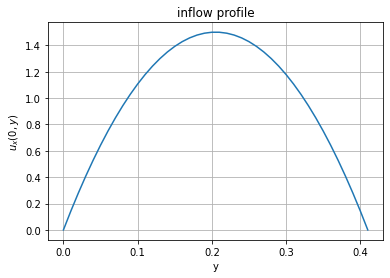

In [6]:
import matplotlib; import numpy as np; import matplotlib.pyplot as plt; 
%matplotlib inline  
s = np.arange(0.0, 0.42, 0.01)
bvs = 6*s*(0.41-s)/(0.41)**2 
plt.plot(s, bvs)
plt.xlabel('y'); plt.ylabel('$u_x(0,y)$'); plt.title('inflow profile')
plt.grid(True)
plt.show()

To solve the Stokes (and later the Navier-Stokes) problem, we introduce the bilinear form:

$$
  a((u,p),(v,q)) := \int_{\Omega} \nu \nabla u : \nabla v - \operatorname{div}(v) p - \operatorname{div}(u) q
$$

In [7]:
(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)   
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

Redraw()
Redraw()

## IMEX time discretization
For the time integration we consider an semi-implicit Euler method (IMEX) where the convection is treated only explicitly and the remaing part implicitly:

Find $(\mathbf{u}^{n+1},p^{n+1}) \in X = \mathbf{V} \times Q$, s.t. for all $(\mathbf{v},q) \in X = \mathbf{V} \times Q$

\begin{align}
\underbrace{m(\mathbf{u}^{n+1},\mathbf{v}) + \Delta t ~\cdot~a((\mathbf{u}^{n+1},p^{n+1}),(\mathbf{v},q))}_{ \to M^\ast} ~=~m(\mathbf{u}^{n},\mathbf{v}) - \Delta t ~\cdot~c(\mathbf{u}^{n}; \mathbf{u}^{n},\mathbf{v}) 
\end{align}

with 
\begin{align}
m(\mathbf{u},\mathbf{v}) = \int \mathbf{u} \cdot \mathbf{v}
\end{align}

and 
\begin{align}
c(\mathbf{w},\mathbf{u},\mathbf{v}) = \int \mathbf{w} \cdot \nabla \mathbf{u} \cdot \mathbf{v}
\end{align}

We prefer the incremental form (as it homogenizes the boundary conditions):
\begin{align}
m(\delta \mathbf{u}^{n+1},\mathbf{v}) + \Delta t ~\cdot~a((\delta \mathbf{u}^{n+1},\delta p^{n+1}),(\mathbf{v},q)) ~=~ \Delta t (-a((\mathbf{u}^{n},p^n),(\mathbf{v},q)) -c(\mathbf{u}^{n}; \mathbf{u}^{n},\mathbf{v}))
\end{align}

In [8]:
dt = 0.001
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

conv = LinearForm(X)
conv += InnerProduct(grad(velocity)*velocity,v)*dx

Instead of assembling a `LinearForm` in every time step, one could use an operator application of a `BilinearForm`, see [unit-2.11](../unit-2.11-matrixfree/matrixfree.ipynb) or the [next unit](../unit-3.3-scalardg/scalardg.ipynb).

In [9]:
t = 0
tend = 0

In [10]:
# implicit Euler/explicit Euler splitting method:
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res    

    t = t + dt
    Redraw()

t= 0.999000000000000876

## Supplementary 1: Computing stresses

In the previously used benchmark the stresses on the obstacle are evaluated, the so-called drag and lift coefficients. 

The force acting on the obstacle is

$$
  F_{\circ} = (F_D,F_L) = \int_{\Gamma_{cyl}} \sigma_n = \int_{\Gamma_{cyl}} (-\nu \frac{\partial u}{\partial n} + p I) \cdot n
$$

The drag/lift coefficients are 

$$
  c_D = \frac{2 }{\bar{u} L} F_D, \quad c_L = \frac{2 }{\bar{u} L} F_L.
$$

where $\bar{u} = 1$ is the mean inflow velocity and $L = 0.41$ is the channel width.

We use the residual of our discretization to compute the forces. On the boundary degrees of freedoms of the disk we overwrote the equation by prescribing the (homogeneous) boundary conditions. The equations related to these dofs describe the force (im)balance at this boundary. 

Testing the residual (functional) with the characteristic function on that boundary (in the x- or y-direction) we obtain the integrated stresses (in the x- or y-direction):

We define the functions which are characteristic functions (in terms of boundary evaluations)

In [11]:
drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

We will collect drag and lift forces over time and therefore create empty arrays

and reset initial data (and time)

In [12]:
time_vals = []
drag_x_vals = []
drag_y_vals = []

In [13]:
# restoring initial data
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

t = 0
tend = 0

With the same discretization as before.

Remarks:
 * you can call the following block several times to continue a simulation and collect more data
 * note that you can reset the array without rerunning the simulation

In [19]:
# implicit Euler/explicit Euler splitting method:
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res    

    t = t + dt
    Redraw()
   
    time_vals.append( t )
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    #print(drag)    

t= 3.9989999999996706

 Below you can plot the gathered drag and lift values:

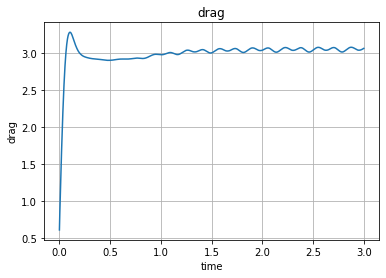

In [17]:
# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()   

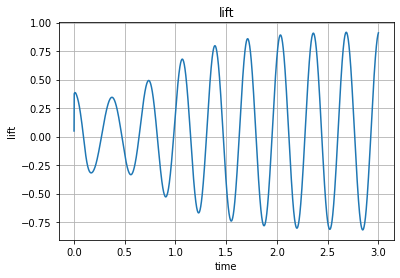

In [18]:
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()    